# Analysis of *in vivo* enzymatic data

This notebook is part of Supporting information of the following publication:
> Combining systems and synthetic biology for in vivo enzymology. Castaño-Cerezo et al., 2024, bioRxiv preprint, doi: 10.1101/2024.02.02.578620

### Content

- Processing functions
- Simulation results
- *In vivo* analyses of phytoene synthase (CrtB)
- *In vivo* analyses of phytoene desaturases (CrtI)
     - CrtI from *Xanthophyllomyces dendrorhous*
     - CrtI from *Pantoea ananatis*
     - CrtI from *Blakeslea trispora*

## Processing functions

In [1]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

sns.set_style("white")

def simulate(x, p):
    """Simulate michaelian curve.

    Args:
        x: substrate concentrations
        p: enzymatic parameters (vmax and km)
    """
    
    vmax = p['vmax'].value
    km = p['km'].value
    
    return vmax * x / (km + x)

def residual(p, x, data):
    """Cost function used to calculate the residuals between 
    experimental and simulated data.

    Args:
        x: measured substrate concentrations
        p: enzymatic parameters (vmax and km)
        data: measured fluxes
    """
    
    return (data - simulate(x, p))

def fit_data(x, y):
    """Estimate michaelien parameters by fitting a Michaelis-Menten 
    rate law to experimental data (fluxes measured at different 
    substrate concentrations).

    Args:
        x: measured substrate concentrations
        y: measured fluxes
    """

    # initialize parameters (vmax and km)
    p = lmfit.Parameters()
    p.add('vmax', value=1., min=0.)
    p.add('km', value=1., min=0.)
    
    # create Minimizer
    mini = lmfit.Minimizer(residual, params=p, fcn_args=(x, y))
    
    # solve with Levenberg-Marquardt algorithm
    out = mini.minimize(method='leastsq')

    # fit experimental data
    mini.minimize()

    return out, mini

def monte_carlo(x, y, n_iter=100, xlim=[0]):
    """Sensitivity analysis to determine the precision on the 
    estimated michaelien parameters.

    Args:
        x: measured substrate concentrations
        y: measured fluxes
        n_iter: number of Monte-Carlo simulations
    """

    # get parameters from the best fit
    out, _ = fit_data(x, y)
    # simulate data from the estimated parameters for
    # the measured substrate concentrations
    out_sim = simulate(x, out.params)

    # generate high-resolution simulated data for 
    # many (200) concentrations, used to estimate 
    # the dispersion of simulated data and for plot
    x_sim = np.arange(0, np.max([np.max(x), np.max(xlim)]), np.max([np.max(x), np.max(xlim)])/200)
    y_sim = simulate(x_sim, out.params)

    # estimate mean error on the fit
    noise = np.std(out.residual)

    # arrays used to store simulation results and parameters
    res_mc_sim = np.empty([n_iter, y_sim.size])
    res_mc_par = np.empty([n_iter, 2])

    # perform monte carlo iterations:
    for i in range(n_iter):
        # generate noisy dataset
        data_noise = np.random.normal(out_sim, [noise]*y.size)
        data_noise[data_noise < 0] = 0
        # estimate parameters
        out_mc, _ = fit_data(x, data_noise)
        res_mc_par[i,] = [out_mc.params['vmax'].value, out_mc.params['km'].value]
        # simulate data for the best fit
        res_mc_sim[i,] = simulate(x_sim, out_mc.params)
    
    # estimate 95% confidence interval on the fit 
    ci_sim = np.empty([2, y_sim.size])
    ci_sim[0,] = np.percentile(res_mc_sim, 2.5, axis=0)
    ci_sim[1,] = np.percentile(res_mc_sim, 97.5, axis=0)

    # calculate statistics on estimated parameters (mean, median, sd, rsd, CI_0.025, CI_0.975) 
    ci_par = {'best fit': [out.params['vmax'].value, out.params['km'].value],
              'mean': np.mean(res_mc_par, axis=0),
              'median': np.median(res_mc_par, axis=0),
              'sd': np.std(res_mc_par, axis=0),
              'rsd': np.std(res_mc_par, axis=0)/np.mean(res_mc_par, axis=0),
              'lower bound (95% ci)': np.percentile(res_mc_par, 2.5, axis=0), 
              'upper bound (95% ci)': np.percentile(res_mc_par, 97.5, axis=0)} 
    ci_par = pd.DataFrame(ci_par, index=['vmax', 'km']) 
    
    return ci_sim, ci_par

def plot_results(x, y, mini, out, results_mc, save=None, plot=dict(), plot_exp=dict(), plot_sim=dict(), plot_resid=dict(), xlab="", ylab="", leglab="", xlim=[0]):
    """Plot results.

    Args:
        x: measured substrate concentrations
        y: measured fluxes
        mini: minimizer object used for parameter estimation
        out: parameter estimation results for the best fit
        results_mc: results of Monte-Carlo analysis
        save: filename(s) to save the plot (if not None)
        plot: additional arguments passed to plt.subplots()
        plot_exp: additional arguments used to plot experimental data
        plot_sim: additional arguments used to plot simulated data
        plot_resid: additional arguments used to plot the distribution of residuals
    """
    
    # initialize plot
    fig, axes = plt.subplots(1, 3, **plot)

    # simulate data for the best fit
    x_sim = np.arange(0, np.max([np.max(x), np.max(xlim)]), np.max([np.max(x), np.max(xlim)])/200)
    y_sim = simulate(x_sim, out.params)

    # plot simulated and experimental data
    axes[0].fill_between(x_sim, results_mc[0,], results_mc[1,], color="#EF553B", alpha=0.3)
    if leglab == "":
        axes[0].plot(x, y, 'o', markersize=5, label='data', **plot_exp)
    else:
        axes[0].plot(x, y, 'o', markersize=5, label=leglab, **plot_exp)
    axes[0].plot(x_sim, y_sim, label='best fit (95% CI)', **plot_sim)
    axes[0].tick_params(bottom=True, left=True)
    if xlab == "":
        axes[0].set_xlabel('concentration')
    else:
        axes[0].set_xlabel(xlab)
    if ylab == "":
        axes[0].set_ylabel('flux')
    else:
        axes[0].set_ylabel(ylab)
    axes[0].legend(frameon=False)
    
    # plot confidence intervals (vmax vs km)
    try:
        cx, cy, grid = lmfit.conf_interval2d(mini, out, 'vmax', 'km', 50, 50)
        ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
        fig.colorbar(ctp, ax=axes[1])
        axes[1].tick_params(bottom=True, left=True)
        axes[1].set_xlabel('vmax')
        axes[1].set_ylabel('km')
    except:
        pass

    # plot distribution of residuals
    sns.histplot(ax=axes[2], data=out.residual, **plot_resid)
    axes[2].tick_params(bottom=True, left=True)
    axes[2].set(xlabel='residual')

    # adjust plot layout
    plt.tight_layout()

    # save figure in file(s)
    if save is not None:
        if isinstance(save, str):
            plt.savefig(save)
        elif isinstance(save, list):
            for i in save:
                plt.savefig(i)

    # display plot
    plt.show()

# Model simulations

In [2]:
low_GGPP = np.float64([1, 1.07809, 1.16583, 1.26506, 1.37811, 1.50799, 1.65865, 1.83537, 2.04541, 2.29898, 2.61093, 3.00374, 3.51316, 4.19959, 5.1739, 6.66394, 9.22425, 14.6484, 33.8091])
low_flux = np.float64([0.01, 0.0103758, 0.0107657, 0.0111702, 0.01159, 0.0120255, 0.0124774, 0.0129463, 0.0134327, 0.0139375, 0.0144613, 0.0150047, 0.0155685, 0.0161535, 0.0167606, 0.0173904, 0.0180439, 0.0187219, 0.0194254])

medium_GGPP = np.float64([0.025641, 0.0266302, 0.0276586, 0.0287278, 0.0298395, 0.0309956, 0.0321978, 0.0334482, 0.0347488, 0.0361017, 0.0375092, 0.0389737, 0.0404975, 0.0420833, 0.0437339, 0.045452, 0.0472407, 0.049103, 0.0510424, 0.0530622, 0.0551662, 0.0573581, 0.059642, 0.0620222, 0.0645032, 0.0670897, 0.0697867, 0.0725995, 0.0755337, 0.0785952, 0.0817902, 0.0851253, 0.0886075, 0.0922443, 0.0960436, 0.100014, 0.104163, 0.108502, 0.11304, 0.117789, 0.122758, 0.127961, 0.133411, 0.139122, 0.145109, 0.151387, 0.157974, 0.164889, 0.172152, 0.179784, 0.187809, 0.196252, 0.205139, 0.214501, 0.22437, 0.234781, 0.245772, 0.257384, 0.269665, 0.282662, 0.296433, 0.311037, 0.326541, 0.343021, 0.360558, 0.379246, 0.399186, 0.420494, 0.4433, 0.46775, 0.49401, 0.522269, 0.552742, 0.585678, 0.621361, 0.660124, 0.702352, 0.7485, 0.799103, 0.8548, 0.916356, 0.984698, 1.06096, 1.14654, 1.24318, 1.35311, 1.47917, 1.62508, 1.79581, 1.99813, 2.24152, 2.53967, 2.91312, 3.39414, 4.03651, 4.93706, 6.28942, 8.54539, 13.0604, 26.6116])
medium_flux = np.float64([0.01, 0.0103758, 0.0107657, 0.0111702, 0.01159, 0.0120255, 0.0124774, 0.0129463, 0.0134327, 0.0139375, 0.0144613, 0.0150047, 0.0155685, 0.0161535, 0.0167606, 0.0173904, 0.0180439, 0.0187219, 0.0194254, 0.0201554, 0.0209128, 0.0216986, 0.022514, 0.0233601, 0.0242379, 0.0251487, 0.0260937, 0.0270742, 0.0280916, 0.0291472, 0.0302425, 0.031379, 0.0325581, 0.0337816, 0.035051, 0.0363681, 0.0377348, 0.0391527, 0.040624, 0.0421506, 0.0437345, 0.0453779, 0.0470831, 0.0488524, 0.0506881, 0.0525929, 0.0545692, 0.0566198, 0.0587474, 0.060955, 0.0632456, 0.0656222, 0.0680881, 0.0706467, 0.0733014, 0.0760559, 0.0789139, 0.0818793, 0.0849561, 0.0881486, 0.091461, 0.0948979, 0.0984639, 0.102164, 0.106003, 0.109986, 0.114119, 0.118408, 0.122857, 0.127474, 0.132264, 0.137234, 0.142391, 0.147742, 0.153294, 0.159054, 0.165031, 0.171232, 0.177667, 0.184343, 0.19127, 0.198458, 0.205916, 0.213653, 0.221682, 0.230012, 0.238656, 0.247624, 0.256929, 0.266584, 0.276601, 0.286995, 0.29778, 0.30897, 0.32058, 0.332627, 0.345126, 0.358095, 0.371551, 0.385513])

high_GGPP = np.float64([0.0144928, 0.0150456, 0.0156198, 0.0162162, 0.0168359, 0.0174796, 0.0181483, 0.0188431, 0.0195651, 0.0203152, 0.0210947, 0.0219048, 0.0227466, 0.0236216, 0.024531, 0.0254763, 0.026459, 0.0274806, 0.0285427, 0.0296471, 0.0307954, 0.0319897, 0.0332317, 0.0345236, 0.0358675, 0.0372655, 0.0387201, 0.0402336, 0.0418087, 0.043448, 0.0451544, 0.0469309, 0.0487804, 0.0507064, 0.0527123, 0.0548017, 0.0569783, 0.0592463, 0.0616098, 0.0640733, 0.0666414, 0.0693193, 0.072112, 0.0750251, 0.0780644, 0.0812362, 0.0845469, 0.0880036, 0.0916135, 0.0953845, 0.0993249, 0.103443, 0.107749, 0.112253, 0.116964, 0.121895, 0.127058, 0.132465, 0.13813, 0.144069, 0.150296, 0.15683, 0.163688, 0.17089, 0.178457, 0.186413, 0.194783, 0.203592, 0.212872, 0.222652, 0.232968, 0.243857, 0.25536, 0.267523, 0.280395, 0.29403, 0.308487, 0.323833, 0.340141, 0.357492, 0.375977, 0.395696, 0.416762, 0.439303, 0.463461, 0.489401, 0.517305, 0.547384, 0.579882, 0.615075, 0.653287, 0.694895, 0.74034, 0.790142, 0.844921, 0.905418, 0.972531, 1.04735, 1.13123, 1.22585, 1.33333])
high_flux = np.float64([0.01, 0.0103758, 0.0107657, 0.0111702, 0.01159, 0.0120255, 0.0124774, 0.0129463, 0.0134327, 0.0139375, 0.0144613, 0.0150047, 0.0155685, 0.0161535, 0.0167606, 0.0173904, 0.0180439, 0.0187219, 0.0194254, 0.0201554, 0.0209128, 0.0216986, 0.022514, 0.0233601, 0.0242379, 0.0251487, 0.0260937, 0.0270742, 0.0280916, 0.0291472, 0.0302425, 0.031379, 0.0325581, 0.0337816, 0.035051, 0.0363681, 0.0377348, 0.0391527, 0.040624, 0.0421506, 0.0437345, 0.0453779, 0.0470831, 0.0488524, 0.0506881, 0.0525929, 0.0545692, 0.0566198, 0.0587474, 0.060955, 0.0632456, 0.0656222, 0.0680881, 0.0706467, 0.0733014, 0.0760559, 0.0789139, 0.0818793, 0.0849561, 0.0881486, 0.091461, 0.0948979, 0.0984639, 0.102164, 0.106003, 0.109986, 0.114119, 0.118408, 0.122857, 0.127474, 0.132264, 0.137234, 0.142391, 0.147742, 0.153294, 0.159054, 0.165031, 0.171232, 0.177667, 0.184343, 0.19127, 0.198458, 0.205916, 0.213653, 0.221682, 0.230012, 0.238656, 0.247624, 0.256929, 0.266584, 0.276601, 0.286995, 0.29778, 0.30897, 0.32058, 0.332627, 0.345126, 0.358095, 0.371551, 0.385513, 0.4])


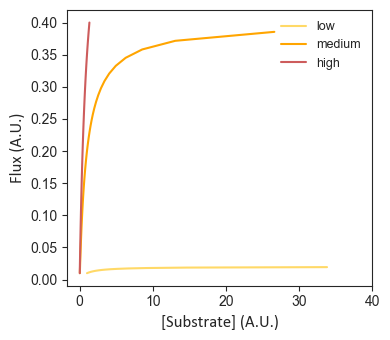

In [3]:

# initialize plot
fig, axes = plt.subplots(1, 1, figsize=(4, 3.5))

# plot simulated and experimental data
axes.plot(low_GGPP, low_flux, label='low', color="#FFD967")
axes.plot(medium_GGPP, medium_flux, label='medium', color="#FFA500")
axes.plot(high_GGPP, high_flux, label='high', color="#CD5C5C")

# plot simulated and experimental data
axes.tick_params(bottom=True, left=True)
axes.set_xlabel('[Substrate] (A.U.)', fontname='Calibri', fontsize="12")
axes.set_ylabel('Flux (A.U.)', fontname='Calibri', fontsize="12")
axes.legend(fontsize="9", frameon=False)

axes.xaxis.set_ticks([0,10,20,30,40])
# adjust plot layout
plt.tight_layout()

# save figure in file(s)
plt.savefig("./figures/simulations.svg")
plt.savefig("./figures/simulations.png")
plt.savefig("./figures/simulations.pdf")

# display plot
plt.show()

# *In vivo* analyses of phytoene synthase (CrtB)

In [4]:
# PGIp
CrtB_pg1p_GGPP = np.float64([0.384, 0.588, 0.542, 2.390, 2.850, 3.241, 7.469, 9.538, 7.217, 7.722, 7.401, 9.722, 18.409, 15.651, 16.984, 20.363, 21.190, 0.230, 0.230, 0.230, 9.193, 8.504, 6.435, 0.460, 0.230, 0.230, 8.734, 7.125, 5.056, 0.414, 0.437, 0.460, 0.115, 0.299, 0.299, 0.345, 0.276, 0.207, 0.276, 0.184, 0.345, 0.161, 0.069, 0.414, 0.437, 0.460, 0.115, 0.299, 0.299, 0.345, 0.276, 0.207, 0.276, 0.184, 0.345, 0.161, 0.069])
CrtB_pg1p_phytoene_flux = np.float64([3.765, 4.344, 4.429, 84.003, 55.159, 80.050, 252.813, 247.067, 232.588, 289.586, 306.363, 286.828, 384.275, 424.036, 432.080, 418.290, 433.689, 1.790, 2.167, 3.298, 250.974, 231.668, 222.016, 9.140, 7.633, 7.161, 250.974, 270.280, 164.098, 22.202, 19.788, 25.741, 1.531, 17.375, 14.847, 19.214, 14.341, 8.504, 14.456, 17.007, 16.548, 1.407, 1.903, 22.202, 19.788, 25.741, 1.531, 17.375, 14.847, 19.214, 14.341, 8.504, 14.456, 17.007, 16.548, 1.407, 1.903])


## PGIp

In [5]:
# fit data
results, mini = fit_data(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, n_iter=1000, xlim=[0,25])

Show results.

In [6]:
results

In [7]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,848.654369,843.378092,834.758195,76.662517,0.090899,715.909705,1017.520922
km,19.120288,18.930314,18.594202,2.837296,0.149881,14.200018,25.437542


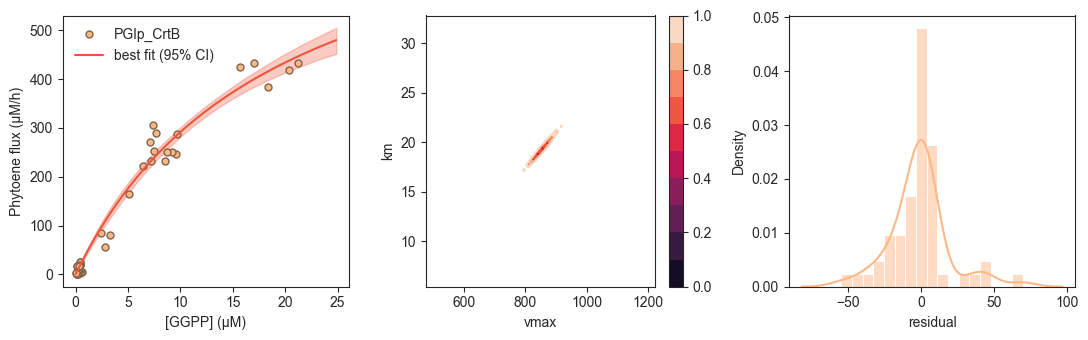

In [8]:
plot_results(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, mini, results, ci_sim,
             save=["./figures/CrtB_pg1p.svg", "./figures/CrtB_pg1p.png", "./figures/CrtB_pg1p.pdf"],
             plot=dict(figsize=(11, 3.5)),
             plot_exp=dict(markerfacecolor="#FEB886", markeredgewidth=1, markeredgecolor="#81624C"),
             plot_sim=dict(color="#EF553B"),
             plot_resid=dict(kde=True, stat="density", color="#FEB886", kde_kws=dict(cut=3)), xlim=[0,25],
             xlab="[GGPP] (µM)", ylab="Phytoene flux (µM/h)", leglab="PGIp_CrtB") 

# Comparison of the results obtained for the three expression levels of CrtB

In [9]:
# PDC1p
CrtB_pdc1p_GGPP = np.float64([1.39, 1.07, 1.05, 1.49, 1.53, 2.11, 1.53, 2.48, 3.37, 1.19, 1.87, 2.25, 1.11, 2.19, 2.61, 3.18, 4.76, 5.77])
CrtB_pdc1p_phytoene_flux = np.float64([8.56, 4.01, 3.04, 198.38, 176.03, 385.86, 343.24, 360.35, 382.24, 397.10, 184.47, 398.29, 600.24, 629.38, 580.09, 589.83, 551.69, 606.44])

# TEF1mut2p
CrtB_tef1mu2p_GGPP = np.float64([0.82, 0.61, 0.58, 3.42, 3.36, 3.26, 11.91, 8.66, 9.31, 16.41, 8.99, 9.56, 20.04, 23.21, 35.16, 24.36, 30.11, 0.23, 0.23, 21.83, 11.72, 20.91])
CrtB_tef1mu2p_phytoene_flux = np.float64([3.28, 1.54, 1.51, 9.88, 11.63, 11.88, 25.69, 25.37, 24.71, 44.47, 47.53, 54.35, 17.03, 31.46, 22.34, 22.66, 22.34, 1.79, 2.17, 53.09, 58.88, 55.99])

# PGIp
CrtB_pg1p_GGPP = np.float64([0.384, 0.588, 0.542, 2.390, 2.850, 3.241, 7.469, 9.538, 7.217, 7.722, 7.401, 9.722, 18.409, 15.651, 16.984, 20.363, 21.190, 0.230, 0.230, 0.230, 9.193, 8.504, 6.435, 0.460, 0.230, 0.230, 8.734, 7.125, 5.056, 0.414, 0.437, 0.460, 0.115, 0.299, 0.299, 0.345, 0.276, 0.207, 0.276, 0.184, 0.345, 0.161, 0.069, 0.414, 0.437, 0.460, 0.115, 0.299, 0.299, 0.345, 0.276, 0.207, 0.276, 0.184, 0.345, 0.161, 0.069])
CrtB_pg1p_phytoene_flux = np.float64([3.765, 4.344, 4.429, 84.003, 55.159, 80.050, 252.813, 247.067, 232.588, 289.586, 306.363, 286.828, 384.275, 424.036, 432.080, 418.290, 433.689, 1.790, 2.167, 3.298, 250.974, 231.668, 222.016, 9.140, 7.633, 7.161, 250.974, 270.280, 164.098, 22.202, 19.788, 25.741, 1.531, 17.375, 14.847, 19.214, 14.341, 8.504, 14.456, 17.007, 16.548, 1.407, 1.903, 22.202, 19.788, 25.741, 1.531, 17.375, 14.847, 19.214, 14.341, 8.504, 14.456, 17.007, 16.548, 1.407, 1.903])

# fit data
results, mini = fit_data(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, n_iter=1000, xlim=[0,40])

# fit data
results2, mini2 = fit_data(CrtB_tef1mu2p_GGPP, CrtB_tef1mu2p_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim2, ci_par2 = monte_carlo(CrtB_tef1mu2p_GGPP, CrtB_tef1mu2p_phytoene_flux, n_iter=1000, xlim=[0,40])

# fit data
results3, mini3 = fit_data(CrtB_pdc1p_GGPP, CrtB_pdc1p_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim3, ci_par3 = monte_carlo(CrtB_pdc1p_GGPP, CrtB_pdc1p_phytoene_flux, n_iter=1000, xlim=[0,40])


In [10]:
# PGIp

results
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,848.654369,844.190576,837.064713,71.941012,0.085219,721.979286,1000.337168
km,19.120288,18.975989,18.733434,2.640061,0.139126,14.703249,24.728792


In [11]:
# TEF1mut2p

results2
ci_par2

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,42.744860,323729.273174,42.002535,6.153772e+06,19.009008,30.360454,75.143411
km,3.783669,192242.092864,3.098715,3.764882e+06,19.584068,0.568741,20.160325


In [12]:
# PDC1

results3
ci_par3

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,1172.566651,9.257816e+07,1130.020156,8.567562e+08,9.254410,516.625835,12626.771421
km,4.740208,6.408258e+05,4.352376,5.961192e+06,9.302358,0.829327,78.537816


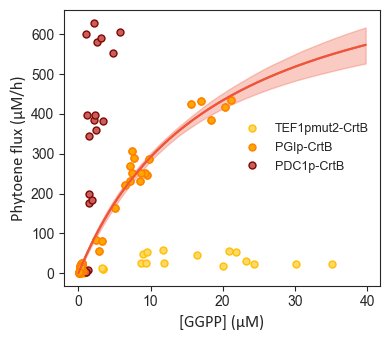

In [13]:
# initialize plot
fig, axes = plt.subplots(1, 1, figsize=(4, 3.5))

# simulate data for the best fit
x_sim = np.arange(0, 40, 40/200)
y_sim = simulate(x_sim, results2.params)

# simulate data for the best fit
x_sim2 = np.arange(0, 40, 40/200)
y_sim2 = simulate(x_sim2, results.params)

# simulate data for the best fit
x_sim3 = np.arange(0, 40, 40/200)
y_sim3 = simulate(x_sim3, results3.params)

# plot simulated and experimental data
axes.plot(CrtB_tef1mu2p_GGPP, CrtB_tef1mu2p_phytoene_flux, 'o', markersize=5, label='TEF1pmut2-CrtB', markerfacecolor="#FFD967", markeredgewidth=1, markeredgecolor="#FFBF00")
axes.plot(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, 'o', markersize=5, label='PGIp-CrtB', markerfacecolor="#FFA500", markeredgewidth=1, markeredgecolor="#FF7F00")
axes.plot(x_sim2, y_sim2, color="#EF553B")
axes.fill_between(x_sim2, ci_sim[0,], ci_sim[1,], color="#EF553B", alpha=0.3)
axes.plot(CrtB_pdc1p_GGPP, CrtB_pdc1p_phytoene_flux, 'o', markersize=5, label='PDC1p-CrtB', markerfacecolor="#CD5C5C", markeredgewidth=1, markeredgecolor="#7C0A02")
axes.plot(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, 'o', markersize=5, markerfacecolor="#FFA500", markeredgewidth=1, markeredgecolor="#FF7F00")
axes.plot(x_sim2, y_sim2, color="#EF553B")

# plot simulated and experimental data
axes.tick_params(bottom=True, left=True)
axes.set_xlabel('[GGPP] (µM)', fontname='Calibri', fontsize="12")
axes.set_ylabel('Phytoene flux (µM/h)', fontname='Calibri', fontsize="12")
axes.legend(fontsize="9", frameon=False)

axes.xaxis.set_ticks([0,10,20,30,40])
# adjust plot layout
plt.tight_layout()

# save figure in file(s)
plt.savefig("./figures/CrtB.svg")
plt.savefig("./figures/CrtB.png")
plt.savefig("./figures/CrtB.pdf")

# display plot
plt.show()

# *In vivo* analysis of phytoene desaturases (CrtI)

## CrtI from *Xanthophyllomyces dendrorhous*

In [14]:
# phytoene concentration
XdCrtI_phytoene = np.float64([944.7255309, 943.038521, 0.421752469, 1.265257407, 2046.34298, 1749.850995, 1582.415264, 1486.255701, 261.9082833, 302.3965204, 949.7865605, 892.8499772, 0, 0, 0, 985.2137679, 951.0518179, 857.4227698, 1767.564598, 1795.400261, 1735.933163, 911.8288383, 1726.232856, 1609.407422, 208.7674722, 203.7064426, 203.2846901, 285.1046691, 292.2744611, 315.8925994, 49.34503889, 50.18854383, 48.07978148, 266.969313, 237.4466401, 233.2291154, 1.687009877, 2.952267284, 0, 1603.92464, 1679.840085, 1741.837698, 1290.562556, 1308.697912, 1159.397538, 384.6382519, 419.6437068, 740.1755834, 698.0003364, 782.3508303, 202.4411852, 202.0194327, 204.1281951, 296.4919858, 254.7384914, 250.0992142, 46.81452408, 44.28400926, 45.1275142, 233.6508679, 260.6430259, 237.0248877])
# lycopene flux
XdCrtI_lycopene_flux = np.float64([124.7965487, 120.7719585, 1.258754814, 1.198814109, 178.452043, 167.7740345, 135.4831202, 105.4271379, 102.8668135, 116.2079019, 138.6428517, 114.4524955, 2.012295111, 1.695465668, 1.507080594, 122.2447872, 139.1480662, 128.0333468, 136.3222901, 126.0981183, 139.7217844, 123.2894681, 172.0298246, 128.5728132, 54.33196799, 40.99944251, 48.16663829, 84.27663184, 93.17354511, 85.1586165, 16.01701279, 24.75122986, 15.2420651, 55.78338936, 58.76329872, 61.65329702, 2.106487648, 3.159731472, 2.63310956, 105.3243824, 109.5373577, 114.2769549, 139.379266, 123.0539868, 120.9474991, 76.00909597, 85.48829038, 102.1646509, 100.0581633, 107.0797888, 46.34272826, 46.51826889, 46.86935017, 73.90260832, 73.20044577, 76.53571788, 22.46920158, 20.53825457, 21.94257967, 52.31110993, 58.80611351, 53.01327247])

In [15]:
# fit data
results, mini = fit_data(XdCrtI_phytoene, XdCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(XdCrtI_phytoene, XdCrtI_lycopene_flux, n_iter=1000, xlim=[0,2500])

Show results.

In [16]:
results

In [17]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,168.412320,168.634939,168.376409,7.208753,0.042748,155.572124,183.867239
km,379.863544,380.577989,377.869375,48.201341,0.126653,296.491907,481.400828


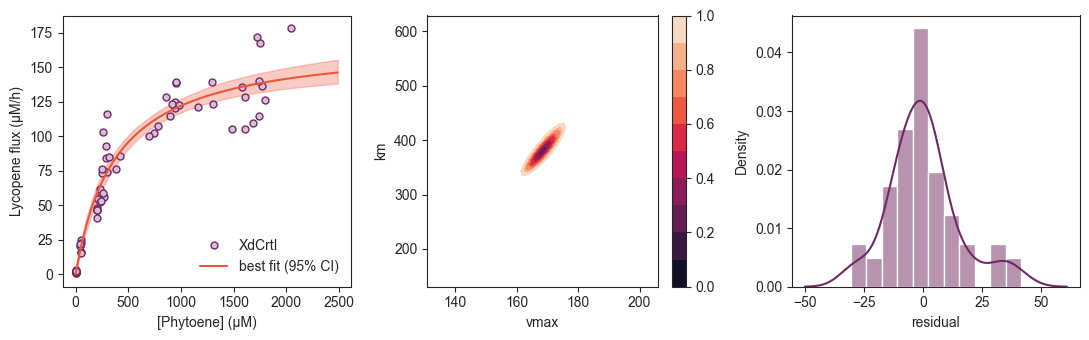

In [18]:
plot_results(XdCrtI_phytoene, XdCrtI_lycopene_flux, mini, results, ci_sim,
             save=["./figures/XdCrtI.svg", "./figures/XdCrtI.png", "./figures/XdCrtI.pdf"],
             plot=dict(figsize=(11, 3.5)),
             plot_exp=dict(markerfacecolor="#D8BFD8", markeredgewidth=1, markeredgecolor="#702963"),
             plot_sim=dict(color="#EF553B"),
             plot_resid=dict(kde=True, stat="density", color="#702963", kde_kws=dict(cut=3)),
             xlim=[0,2500],
             xlab="[Phytoene] (µM)", ylab="Lycopene flux (µM/h)", leglab="XdCrtI") 

## CrtI from *Pantoea ananatis*

In [19]:
# phytoene concentration
PaCrtI_phytoene = np.float64([940.0862537, 1005.457886, 4.639277161, 4.217524692, 1449.563236, 1490.473226, 1414.557782, 1200.307527, 338.2454803, 376.2032025, 944.3037784, 829.5871068, 5.904534568, 7.591544445, 5.482782099, 1080.108073, 1053.95942, 1045.102619, 2150.937593, 2016.820307, 1961.148982, 1889.029309, 1835.044993, 1789.495727, 6.748039506, 5.06102963, 7.169791976, 1790.339232, 1681.527095, 1814.379122, 482.9065772, 517.9120321, 499.7766759, 0, 924.0596599, 1058.598698])
# lycopene flux
PaCrtI_lycopene_flux = np.float64([4.795256435, 4.564056571, 0, 0, 6.182455617, 6.679107177, 4.795256435, 3.930397685, 2.115050606, 2.63310956, 4.212975296, 3.510812747, 0.184103595, 0, 0.141288806, 7.278514231, 7.762321353, 8.091995233, 12.66461476, 10.93061578, 15.64452412, 10.94346022, 11.09759346, 8.151935939, 0.175540637, 0.175540637, 0.175540637, 16.67636055, 16.14973863, 17.02744182, 10.18135697, 10.3568976, 11.23460079, 0, 7.723788043, 8.601491229])

In [20]:
# fit data
results, mini = fit_data(PaCrtI_phytoene, PaCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(PaCrtI_phytoene, PaCrtI_lycopene_flux, n_iter=10000, xlim=[0,2500])

Show results.

In [21]:
results

In [22]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,40.538440,5.510245e+06,37.038352,2.273765e+07,4.126432,13.268964,7.455862e+07
km,4525.962909,8.276806e+08,3988.321309,3.394510e+09,4.101232,597.817992,1.139805e+10


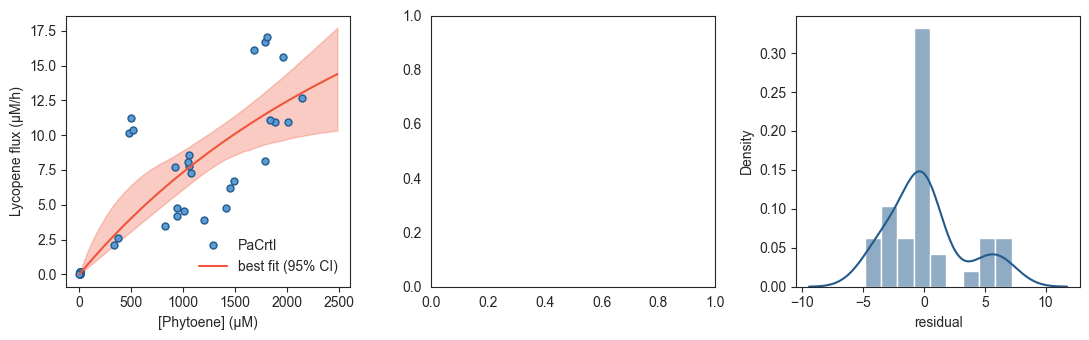

In [23]:
plot_results(PaCrtI_phytoene, PaCrtI_lycopene_flux, mini, results, ci_sim,
             save=["./figures/PaCrtI.svg", "./figures/PaCrtI.png", "./figures/PaCrtI.pdf"],
             plot=dict(figsize=(11, 3.5)),
             plot_exp=dict(markerfacecolor="#5B9BD5", markeredgewidth=1, markeredgecolor="#225A8C"),
             plot_sim=dict(color="#EF553B"),
             plot_resid=dict(kde=True, stat="density", color="#225A8C", kde_kws=dict(cut=3)),
             xlim=[0,2500],
             xlab="[Phytoene] (µM)", ylab="Lycopene flux (µM/h)", leglab="PaCrtI") 

## CrtI from *Blakeslea trispora*

In [24]:
# phytoene concentration
BtCrtI_phytoene = np.float64([4.5498e-11, 7.16043e-11, 5.83074e-11, 425.8979942, 466.0111087, 450.5714745, 804.3820197, 800.1878115, 843.39871, 25.65958167, 163.2663664, 153.684233, 104.7860927, 100.1267329, 108.3409435, 13.93487416, 24.75926007, 22.54114005, 108.2371067, 68.65009639, 59.4336431])
# lycopene flux
BtCrtI_lycopene_flux = np.float64([7.111893703, 8.061019082, 7.491143756, 270.2873056, 319.2802888, 285.0495263, 300.8581289, 266.7920683, 307.5923021, 253.2127748, 301.158852, 267.9379311, 227.7921724, 210.9660681, 216.4953912, 65.69072403, 123.3973453, 125.5335503, 189.7000527, 112.9620463, 95.68464831])


In [25]:
# fit data
results, mini = fit_data(BtCrtI_phytoene, BtCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(BtCrtI_phytoene, BtCrtI_lycopene_flux, n_iter=1000, xlim=[0,300])

Show results.

In [26]:
results

In [27]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,309.360278,310.943039,309.662246,22.191573,0.071369,271.955234,357.105465
km,41.167296,42.537911,41.162870,12.242604,0.287805,23.054289,69.831202


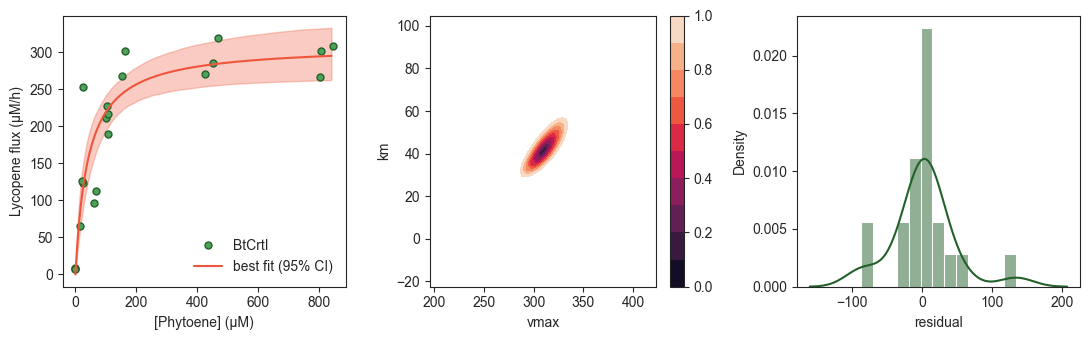

In [28]:
plot_results(BtCrtI_phytoene, BtCrtI_lycopene_flux, mini, results, ci_sim,
             save=["./figures/BtCrtI.svg", "./figures/BtCrtI.png", "./figures/BtCrtI.pdf"],
             plot=dict(figsize=(11, 3.5)),
             plot_exp=dict(markerfacecolor="#4fA15A", markeredgewidth=1, markeredgecolor="#23612B"),
             plot_sim=dict(color="#EF553B"),
             plot_resid=dict(kde=True, stat="density", color="#23612B", kde_kws=dict(cut=3)),
             xlim=[0,300],
             xlab="[Phytoene] (µM)", ylab="Lycopene flux (µM/h)", leglab="BtCrtI") 